# Loading the sensor and PLC data from csv files

In [ ]:
# References
# https://github.com/Kumaava/RUL-from-Vibration-Signal/blob/master/Nanoprecise.ipynb
# https://github.com/lankuohsing/Remaining-Useful-Life-Prediction-RNN
# https://github.com/Featuretools/predict-remaining-useful-life/blob/c6a78c7b1922b8144c54dc2359e0e66fc5425b7d//Simple%20Featuretools%20RUL%20Demo.ipynb
# https://github.com/biswajitsahoo1111/rul_codes_open/tree/master/notebooks/cmapss_notebooks
# https://github.com/leepingtay/time_series_forecasting_energy/blob/master/Energy_Time_Series_Forecast_XGBoost.ipynb
# https://github.com/JohnTaco93/Foxconn-industrial-AI-Data-Challenge/blob/master/PLC_data_baseline.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os

In [ ]:
import sys
sys.path.append('/content/gdrive/')

Loading and setting up the data

In [ ]:
main_path = "/content/gdrive/MyDrive/COEN 4890 Final"

train_plc_1 = "/Training Data-01/Training Data-01/PLC/plc.csv"
train_plc_2 = "/Training Data-02/Training Data-02/PLC/plc.csv"
train_plc_3 = "/Training Data-03/Training Data-03/PLC/plc.csv"

test_plc_1 = "/Testing Data-01/Testing Data-01/PLC/plc.csv"
test_plc_2 = "/Testing Data-02/Testing Data-02/PLC/plc.csv"
test_plc_3 = "/Testing Data-03/Testing Data-03/PLC/plc.csv"
test_plc_4 = "/Testing Data-04/Testing Data-04/PLC/plc.csv"
test_plc_5 = "/Testing Data-05/Testing Data-05/PLC/plc.csv"

In [ ]:
training_1 = "/Training Data-01/Training Data-01/Sensor/"
training_2 = "/Training Data-02/Training Data-02/Sensor/"
training_3 = "/Training Data-03/Training Data-03/Sensor/"

testing_1 = "/Testing Data-01/Testing Data-01/Sensor/"
testing_2 = "/Testing Data-02/Testing Data-02/Sensor/"
testing_3 = "/Testing Data-03/Testing Data-03/Sensor/"
testing_4 = "/Testing Data-04/Testing Data-04/Sensor/"
testing_5 = "/Testing Data-05/Testing Data-05/Sensor/"

In [ ]:
train_plc_1 = pd.read_csv(main_path+train_plc_1)
train_plc_2 = pd.read_csv(main_path+train_plc_2)
train_plc_3 = pd.read_csv(main_path+train_plc_3)

In [ ]:
test_plc_1 = pd.read_csv(main_path+test_plc_1)
test_plc_2 = pd.read_csv(main_path+test_plc_2)
test_plc_3 = pd.read_csv(main_path+test_plc_3)
test_plc_4 = pd.read_csv(main_path+test_plc_4)
test_plc_5 = pd.read_csv(main_path+test_plc_5)

In [ ]:
def read_sensor_data(train):
    sensor_data = pd.DataFrame()
    bad_list = []
    csv_lengths = []
    # look through all csv files, and limit the vibration amplitude to 30 from explanatory analysis
    for i in range(48):
        path_to_file = main_path + train + str(1+i) + '.csv'
        if os.path.exists(path_to_file):
            training_data = pd.read_csv(path_to_file)
            training_data.loc[abs(training_data.vibration_1)>30, 'vibration_1'] = training_data.loc[abs(training_data.vibration_1)<30]["vibration_1"].mean()
            training_data.loc[abs(training_data.vibration_2)>30, 'vibration_2'] = training_data.loc[abs(training_data.vibration_2)<30]["vibration_2"].mean()
            training_data.loc[abs(training_data.vibration_3)>30, 'vibration_3'] = training_data.loc[abs(training_data.vibration_3)<30]["vibration_3"].mean()
            csv_lengths.append(len(training_data))
            training_data['csv_no'] = i+1
            sensor_data = sensor_data.append(training_data, ignore_index = True)
        else:
            bad_list.append(i+1)
            csv_lengths.append(0)
    return sensor_data, bad_list, csv_lengths

In [ ]:
def shrink(sensor_data, bad_list, plc_csv_lengths):
    final_df = pd.DataFrame()
    for number in range(48):
        if (bad_list.count(number + 1) == 0):
            focus_data = sensor_data[sensor_data['csv_no'] == number + 1] # get the desired csv file
            per_csv = math.floor(len(focus_data) / plc_csv_lengths[number]) # get the number of rows per section, each section -> one plc row
            remainder = 0
            start = 0
            end = per_csv
            vib1 = []
            vib2 = []
            vib3 = []
            cur = []
            no = []
            # sync a number of sensor csv rows and to one plc row based on each csv
            for i in range(int(plc_csv_lengths[number])):
                if(i == plc_csv_lengths[number]-1):
                    remainder = len(focus_data)-math.floor(len(focus_data) / plc_csv_lengths[number]) * plc_csv_lengths[number]
                section_data = focus_data.iloc[start:end + remainder]
                vib1.append(section_data['vibration_1'].mean())
                vib2.append(section_data['vibration_2'].mean())
                vib3.append(section_data['vibration_3'].mean())
                cur.append(section_data['current'].mean())
                no.append(section_data['csv_no'].to_list()[0])
                start = start + per_csv
                end = end + per_csv
            new_df = pd.DataFrame()
            new_df['vibration_1'] = vib1
            new_df['vibration_2'] = vib2
            new_df['vibration_3'] = vib3
            new_df['current'] = cur
            new_df['csv_no'] = no
            final_df = final_df.append(new_df, ignore_index = True)
    return final_df

In [ ]:
def process_plc_data(df):
    df['time'] = pd.to_datetime(df.time, format = '%H:%M:%S:%f')
    df['last_time'] = df['time'].max()
    df['rul'] = df['last_time'] - df['time']
    df['rul'] = df['rul'] / np.timedelta64(1, 'm')
    df.drop(['time', 'last_time'], axis = 1, inplace = True)

    plc_csv_lengths = []
    time_list = []
    the_max = df.csv_no.max()

    for i in range(0, the_max):
        temp_df = df[df['csv_no'] == i + 1]
        time_gap = temp_df['rul'].max() - temp_df['rul'].min()
        time_list.append(time_gap)
        plc_csv_lengths.append(len(temp_df))

    end_df = pd.DataFrame()

    for i in range(0, the_max):
        focus_df = df[df['csv_no'] == i + 1]
        temp_list = (5*(the_max-i)-(focus_df['rul']-focus_df['rul'].min()).iloc[::-1]).to_list()
        focus_df['real_time'] = temp_list
        end_df = pd.concat([end_df, focus_df], axis = 0)

    end_df.drop('rul', inplace = True, axis = 1)
    # end_df.to_csv(main_path+'/plc1_train.csv', index = False)
    plc_sample_rates = []
    for i in range(0, the_max):
        plc_sample_rates.append(plc_csv_lengths[i]/(time_list[i]*60))
    return end_df, plc_csv_lengths

Getting the training data dataframes, corrupted csv number list, and length of dataframes for each csv

In [ ]:
train_1, bad_list_1, _ = read_sensor_data(training_1)
train_2, bad_list_2, _ = read_sensor_data(training_2)
train_3, bad_list_3, _ = read_sensor_data(training_3)

In [ ]:
train_plc_1, train_len_1 = process_plc_data(train_plc_1)
train_plc_2, train_len_2 = process_plc_data(train_plc_2)
train_plc_3, train_len_3 = process_plc_data(train_plc_3)

Shrinks the sensor data to "match", or be in sync with the PLC data. The sampling rates for the sensor data, and PLC data are not constant

In [ ]:
train_1 = shrink(train_1, bad_list_1, train_len_1)
train_2 = shrink(train_2, bad_list_2, train_len_2)
train_3 = shrink(train_3, bad_list_3, train_len_3)

In [ ]:
train_1.to_csv(main_path+'/sensor1_train.csv')
train_2.to_csv(main_path+'/sensor2_train.csv')
train_3.to_csv(main_path+'/sensor3_train.csv')

In [ ]:
train_1 = pd.read_csv(main_path+'/sensor1_train.csv')
train_2 = pd.read_csv(main_path+'/sensor2_train.csv')
train_3 = pd.read_csv(main_path+'/sensor3_train.csv')

Getting the testing data dataframes, corrupted csv number list, and length of dataframes for each csv

In [ ]:
test_1, bad_list_1, _ = read_sensor_data(testing_1)
test_2, bad_list_2, _ = read_sensor_data(testing_2)
test_3, bad_list_3, _ = read_sensor_data(testing_3)
test_4, bad_list_4, _ = read_sensor_data(testing_4)
test_5, bad_list_5, _ = read_sensor_data(testing_5)

Processing plc data to add the RUL column

In [ ]:
test_plc_1, test_len_1 = process_plc_data(test_plc_1)
test_plc_2, test_len_2 = process_plc_data(test_plc_2)
test_plc_3, test_len_3 = process_plc_data(test_plc_3)
test_plc_4, test_len_4 = process_plc_data(test_plc_4)
test_plc_5, test_len_5 = process_plc_data(test_plc_5)

Shrinks the sensor data to "match", or be in sync with the PLC data. The sampling rates for the sensor data, and PLC data are not constant

In [ ]:
test_1 = shrink(test_1, bad_list_1, test_len_1)
test_2 = shrink(test_2, bad_list_2, test_len_2)
test_3 = shrink(test_3, bad_list_2, test_len_3)
test_4 = shrink(test_4, bad_list_2, test_len_4)
test_5 = shrink(test_5, bad_list_2, test_len_5)

In [ ]:
test_1.to_csv(main_path+'/sensor1_test.csv')
test_2.to_csv(main_path+'/sensor2_test.csv')
test_3.to_csv(main_path+'/sensor3_test.csv')
test_4.to_csv(main_path+'/sensor4_test.csv')
test_5.to_csv(main_path+'/sensor5_test.csv')

In [ ]:
test_1 =  pd.read_csv(main_path+'/sensor1_test.csv')
test_2 =  pd.read_csv(main_path+'/sensor2_test.csv')
test_3 =  pd.read_csv(main_path+'/sensor3_test.csv')
test_4 =  pd.read_csv(main_path+'/sensor4_test.csv')
test_5 =  pd.read_csv(main_path+'/sensor5_test.csv')

# Preprocessing the sensor and PLC data



In [ ]:
def filter_signal(signal, threshold = 1e8):
    fourier = np.fft.rfft(signal)
    frequencies = np.fft.rfftfreq(len(signal), d = 1e-5)
    fourier[frequencies > threshold] = 0
    return np.fft.irfft(fourier)

In [ ]:
def agg_vibr(df, aggs):
  df = df.reset_index().groupby('csv_no').agg(aggs)
  df.columns = df.columns.map('_'.join)
  df = df.reset_index()
  return df

In [ ]:
def feature_gen(df):
    for thres in [1e1, 1e2]:
        df['vibration_1_thres' + str(int(thres))] = pd.Series(filter_signal(df.vibration_1, threshold = thres))
        df['vibration_2_thres' + str(int(thres))] = pd.Series(filter_signal(df.vibration_2, threshold = thres))
    aggs = {'current': ['mean', 'std', 'max', 'skew'],
    'vibration_1_thres100': ['mean', 'std', 'max', 'skew'],
    'vibration_2_thres100': ['mean', 'std', 'max', 'skew'],
    }
    df_agg = agg_vibr(df, aggs)
    for i in range(1, 3):
        df['vibration_' + str(i) + '_thres100_sqr'] = df['vibration_' + str(i) + '_thres100'] ** 2
        df_agg['vibration_'+str(i) + '_thres100_rms'] = np.sqrt(df.groupby('csv_no')['vibration_' + str(i) + '_thres100_sqr'].mean()).values
        df_agg['vibration_'+str(i) + '_thres100_kurt'] = df.groupby('csv_no')['vibration_' + str(i) + '_thres100'].apply(pd.DataFrame.kurt).values
        df_agg['vibration_'+str(i) + '_thres100_cest_fct'] = df_agg['vibration_' + str(i) + '_thres100_max']/df_agg['vibration_' + str(i) + '_thres100_rms']
    df_agg['RUL'] = 240-(df_agg['csv_no'] - 1) * 5
    df_agg['Cycle'] = df_agg['csv_no']
    df_agg.drop('csv_no', axis = 1, inplace = True)
    return df_agg

Generate additional features for the training data, and merge it with the plc data. Remove the Z component since it was shown to be monotonic in explanatory data analysis

In [ ]:
train1_agg = feature_gen(train_1)
train2_agg = feature_gen(train_2[:-1])
train3_agg = feature_gen(train_3[:-1])

temp_1 = train_plc_1[train_plc_1['csv_no']!= 40].groupby('csv_no').mean().reset_index().drop(['csv_no', 'z'], axis = 1)
temp_2 = train_plc_2[train_plc_2['csv_no']!= 25].groupby('csv_no').mean().reset_index().drop(['csv_no', 'z'], axis = 1)
temp_3 = train_plc_3.groupby('csv_no').mean().reset_index().drop(['csv_no', 'z'], axis = 1)

train1_agg = pd.concat([temp_1, train1_agg], axis = 1)
train2_agg = pd.concat([temp_2, train2_agg], axis = 1)
train3_agg = pd.concat([temp_3, train3_agg], axis = 1)

train1_agg['UnitNumber'] = 1
train2_agg['UnitNumber'] = 2
train3_agg['UnitNumber'] = 3

train1_agg = train1_agg.drop(['real_time'], axis = 1)
train2_agg = train2_agg.drop(['real_time'], axis = 1)
train3_agg = train3_agg.drop(['real_time'], axis = 1)
train3_agg['RUL'] = train3_agg['RUL']-(240-185)

In [ ]:
train1_agg.head()

,spindle_load,x,y,current_mean,current_std,current_max,current_skew,vibration_1_thres100_mean,vibration_1_thres100_std,vibration_1_thres100_max,vibration_1_thres100_skew,vibration_2_thres100_mean,vibration_2_thres100_std,vibration_2_thres100_max,vibration_2_thres100_skew,vibration_1_thres100_rms,vibration_1_thres100_kurt,vibration_1_thres100_cest_fct,vibration_2_thres100_rms,vibration_2_thres100_kurt,vibration_2_thres100_cest_fct,RUL,Cycle,UnitNumber
0,0.914081,-356.155884,44.528058,-11.144181,15.047187,16.499980,-0.667825,0.032376,0.001531,0.037220,0.943986,-0.013055,0.003116,-0.004245,0.369418,0.032412,0.879174,1.148343,0.013422,-0.047324,-0.316309,240,1,1
1,13.331341,-737.676705,115.590290,-0.318225,3.310288,4.773624,0.000877,0.033744,0.001075,0.035050,-0.790154,-0.009465,0.001129,-0.007995,-0.846165,0.033761,-0.611434,1.038168,0.009532,0.139301,-0.838746,235,2,1
2,13.701669,-737.856319,105.071377,-0.330913,3.247888,4.648541,-0.001015,0.030841,0.000615,0.031982,0.430435,-0.012528,0.000621,-0.011608,-0.738537,0.030847,-0.985877,1.036816,0.012544,0.125829,-0.925403,230,3,1
3,13.355145,-736.889246,114.687300,-0.322211,3.132506,4.413352,-0.001984,0.028955,0.000676,0.030533,0.715187,-0.013793,0.000482,-0.013162,-0.328034,0.028963,-0.668608,1.054205,0.013801,-0.900349,-0.953728,225,4,1
4,13.851032,-757.617073,119.884201,-0.317865,3.238111,4.595174,0.002794,0.030467,0.000436,0.031239,-0.064887,-0.012187,0.000754,-0.010854,0.667846,0.030470,-0.921646,1.025257,0.012210,-1.137726,-0.888960,220,5,1


Generate additional features for the training data, and merge it with the plc data. Remove the Z component since it was shown to be monotonic in explanatory data analysis

In [ ]:
temp_1 = test_plc_1.groupby('csv_no').mean().reset_index().drop(['csv_no', 'z'], axis = 1)
temp_2 = test_plc_2.groupby('csv_no').mean().reset_index().drop(['csv_no', 'z'], axis = 1)
temp_3 = test_plc_3.groupby('csv_no').mean().reset_index().drop(['csv_no', 'z'], axis = 1)
temp_4 = test_plc_4.groupby('csv_no').mean().reset_index().drop(['csv_no', 'z'], axis = 1)
temp_5 = test_plc_5.groupby('csv_no').mean().reset_index().drop(['csv_no', 'z'], axis = 1)

test1_agg = feature_gen(test_1[:-1])
test2_agg = feature_gen(test_1[:-1])
test3_agg = feature_gen(test_3[:-1])
test4_agg = feature_gen(test_4[:-1])
test5_agg = feature_gen(test_5[:-1])

test1_agg = pd.concat([temp_1, test1_agg], axis = 1)
test2_agg = pd.concat([temp_2, test2_agg], axis = 1)
test3_agg = pd.concat([temp_3, test3_agg], axis = 1)
test4_agg = pd.concat([temp_4, test4_agg], axis = 1)
test5_agg = pd.concat([temp_5, test5_agg], axis = 1)

test1_agg = test1_agg.drop(['real_time'], axis = 1)
test2_agg = test2_agg.drop(['real_time'], axis = 1)
test3_agg = test3_agg.drop(['real_time'], axis = 1)
test4_agg = test4_agg.drop(['real_time'], axis = 1)
test5_agg = test5_agg.drop(['real_time'], axis = 1)

test1_agg['Cycle'] = test1_agg['Cycle'] + 8 - 1
test2_agg['Cycle'] = test2_agg['Cycle'] + 14 - 1
test3_agg['Cycle'] = test3_agg['Cycle'] + 10 - 1
test4_agg['Cycle'] = test4_agg['Cycle'] + 14 - 1
test5_agg['Cycle'] = test5_agg['Cycle'] + 24 - 1

In [ ]:
test1_agg.head()

,spindle_load,x,y,current_mean,current_std,current_max,current_skew,vibration_1_thres100_mean,vibration_1_thres100_std,vibration_1_thres100_max,vibration_1_thres100_skew,vibration_2_thres100_mean,vibration_2_thres100_std,vibration_2_thres100_max,vibration_2_thres100_skew,vibration_1_thres100_rms,vibration_1_thres100_kurt,vibration_1_thres100_cest_fct,vibration_2_thres100_rms,vibration_2_thres100_kurt,vibration_2_thres100_cest_fct,RUL,Cycle
0,0.056705,-636.564300,46.728800,50.300984,0.016688,50.360500,0.120451,0.036634,0.001063,0.037902,-1.047897,-0.001638,0.001003,-0.000159,-0.724494,0.036650,0.140848,1.034171,0.001921,0.385819,-0.082877,240,8
1,14.836691,-241.655016,129.768672,-0.301727,1.617739,2.347636,-0.000423,0.030384,0.001305,0.033637,0.095646,-0.004970,0.001224,-0.002776,-0.385992,0.030412,-0.976303,1.106049,0.005119,-1.059616,-0.542364,235,9
2,15.368488,-252.051477,138.808075,-0.301506,0.548863,0.959667,0.029200,0.030026,0.000606,0.030611,-0.840204,-0.003741,0.000509,-0.002986,-0.552072,0.030033,-0.874822,1.019252,0.003776,-0.321715,-0.790778,230,10
3,15.361418,-246.874731,132.580058,-0.306370,1.143487,1.784409,0.002675,0.031564,0.000796,0.032611,-0.713664,-0.004195,0.000779,-0.002922,-0.518114,0.031574,-1.056968,1.032850,0.004266,-1.095685,-0.684858,225,11
4,13.457013,-236.853588,125.540566,-0.316253,0.339134,0.638736,0.069707,0.032660,0.000817,0.034103,0.090309,-0.004077,0.001396,-0.002068,-0.409302,0.032670,-0.376711,1.043850,0.004309,-0.712097,-0.479880,220,12


# XGBoost Model training and testing

Normalize inputs with L2

In [ ]:
from sklearn.preprocessing import Normalizer as NRM

In [ ]:
y = train1_agg.RUL
l2 = np.linalg.norm([y], ord = 2, axis = 1)
x_norm2 = [y] / l2[:, None]
x_norm2

array([[0.24641969, 0.24128595, 0.2361522 , 0.23101846, 0.22588471,
        0.22075097, 0.21561723, 0.21048348, 0.20534974, 0.200216  ,
        0.19508225, 0.18994851, 0.18481477, 0.17968102, 0.17454728,
        0.16941354, 0.16427979, 0.15914605, 0.15401231, 0.14887856,
        0.14374482, 0.13861107, 0.13347733, 0.12834359, 0.12320984,
        0.1180761 , 0.11294236, 0.10780861, 0.10267487, 0.09754113,
        0.09240738, 0.08727364, 0.0821399 , 0.07700615, 0.07187241,
        0.06673867, 0.06160492, 0.05647118, 0.05133744, 0.04106995,
        0.0359362 , 0.03080246, 0.02566872, 0.02053497, 0.01540123,
        0.01026749, 0.00513374]])

In [ ]:
results = x_norm2*l2[:, None]
results

array([[240., 235., 230., 225., 220., 215., 210., 205., 200., 195., 190.,
        185., 180., 175., 170., 165., 160., 155., 150., 145., 140., 135.,
        130., 125., 120., 115., 110., 105., 100.,  95.,  90.,  85.,  80.,
         75.,  70.,  65.,  60.,  55.,  50.,  40.,  35.,  30.,  25.,  20.,
         15.,  10.,   5.]])

In [ ]:
denorm=l2[:, None][0]

Combine all training data

In [ ]:
train_agg = pd.concat([train1_agg, train2_agg, train3_agg])

In [ ]:
from sklearn.utils import shuffle

In [ ]:
def splits(train_agg):
    y = train_agg.RUL
    l2 = np.linalg.norm([y], ord = 2, axis = 1)
    x_norm2 = [y] / l2[:, None]
    y = x_norm2[0]

    X = train_agg.drop(["RUL", "UnitNumber"], axis = 1)
    clone_agg=train_agg
    clone_agg['RUL']=x_norm2[0]

    unit1 = shuffle(clone_agg[clone_agg['UnitNumber'] == 1]).reset_index().drop('index',axis=1)
    unit2 = shuffle(clone_agg[clone_agg['UnitNumber'] == 2]).reset_index().drop('index',axis=1)
    unit3 = shuffle(clone_agg[clone_agg['UnitNumber'] == 3]).reset_index().drop('index',axis=1)
    train = pd.concat([unit1.iloc[0:math.floor(int(len(unit1)*0.8))], unit2.iloc[0:math.floor(int(len(unit1)*0.8))], unit3.iloc[0:math.floor(int(len(unit1)*0.8))]]).reset_index().drop('index',axis=1)
    test = pd.concat([unit1.iloc[math.floor(int(len(unit1)*0.8)):], unit2.iloc[math.floor(int(len(unit1)*0.8)):], unit3.iloc[math.floor(int(len(unit1)*0.8)):]]).reset_index().drop('index',axis=1)

    X_train = train.drop(['RUL','UnitNumber'], axis = 1)
    y_train = np.array(train.RUL)

    X_test = test.drop(['RUL','UnitNumber'], axis = 1)
    y_test = np.array(test.RUL)

    return X_train, X_test, y_train, y_test, X, y, l2

Get 80/20 splits for each unit:1, 2, 3

This is to prevent overfitting

In [ ]:
X_train, X_test, y_train, y_test, X, y, l2 = splits(train_agg)

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  train_test_split

Training and testing a XGBoost model

[21:08:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cross validation  : 3.274977856024587e-05
train set  : 2.3737838316955427e-06
train set  : 7.011340278802463e-06


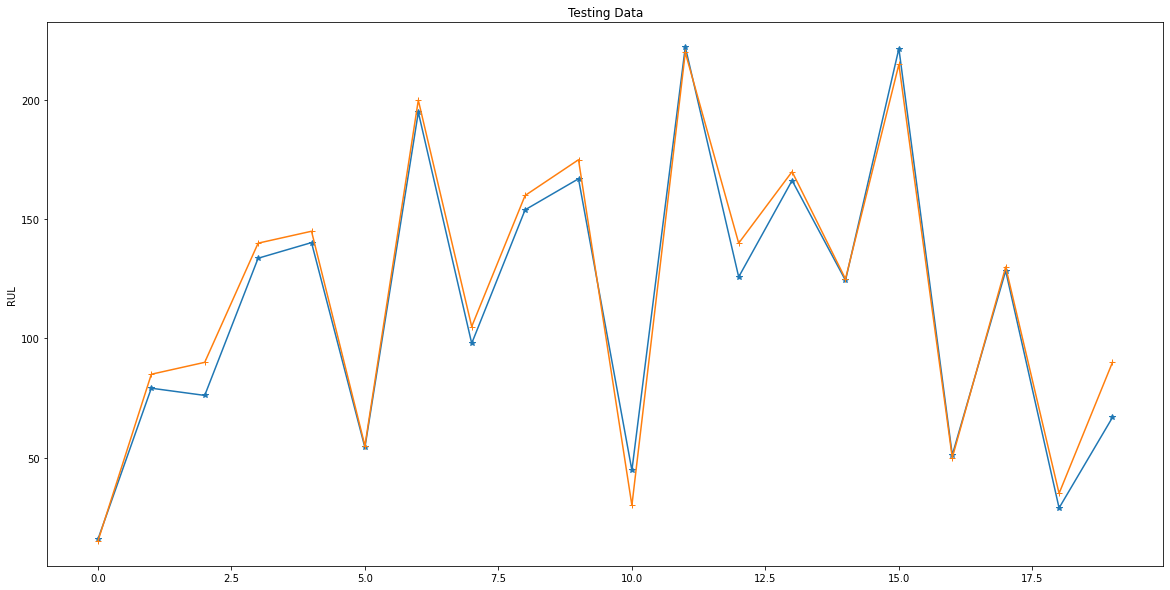

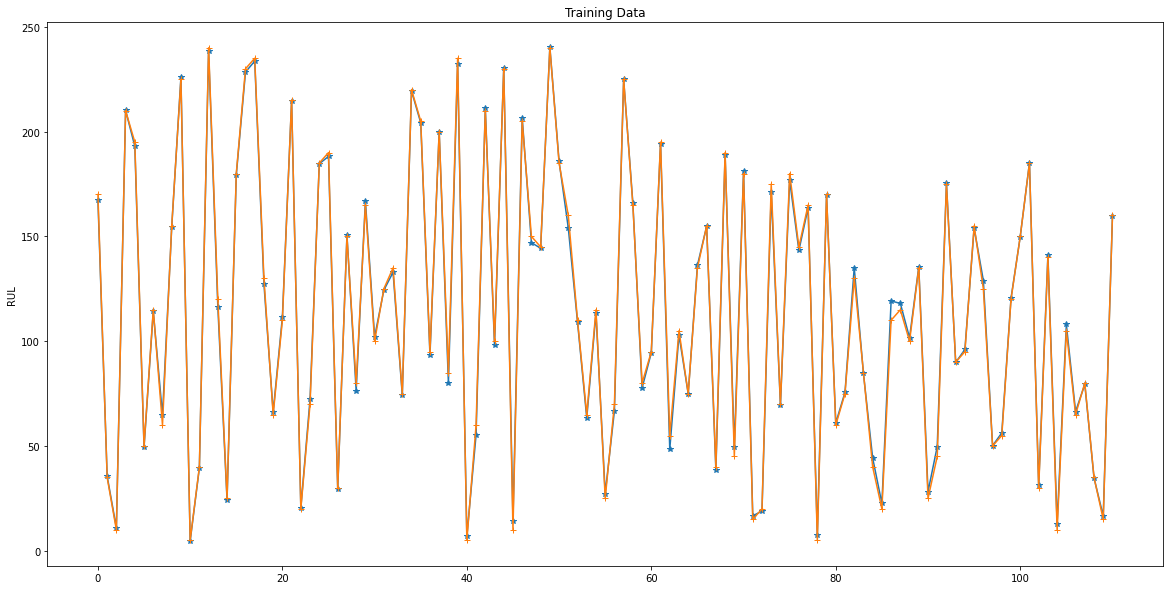

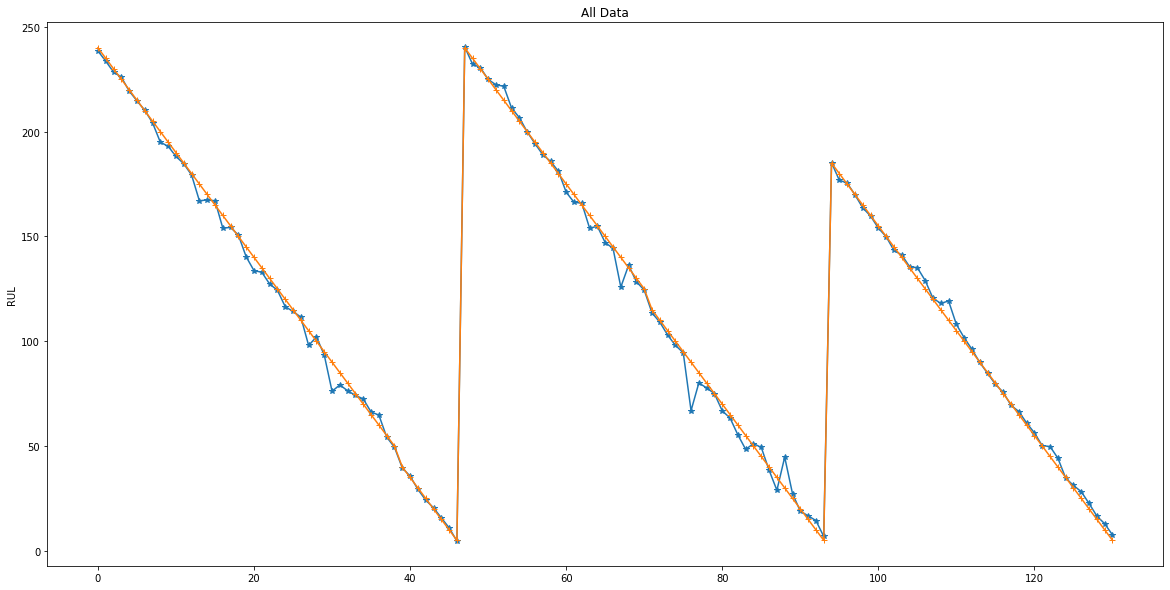

In [ ]:
import xgboost as xgb
xgbr = xgb.XGBRegressor()

### validation set
#xgbr.train(X_train, y_train)
xgbr.fit(X_train, y_train)
pred  = xgbr.predict(X_test)
print ("cross validation  :" , mean_squared_error(pred, y_test))

plt.figure(figsize = (20, 10))
plt.title("Testing Data")
plt.ylabel("RUL")
plt.plot(pred*denorm, marker = "*", )
plt.plot(y_test*denorm, marker = "+")

### train set
#xgbr.fit(X_train, y_train)
pred1  = xgbr.predict(X_train)
print ("train set  :", mean_squared_error(pred1, y_train))

plt.figure(figsize = (20, 10))
plt.title("Training Data")
plt.ylabel("RUL")
plt.plot(pred1*denorm, marker = "*", )
plt.plot(y_train*denorm, marker = "+")


### whole data
#xgbr.fit(X, y)

pred_fulldata  = xgbr.predict(X)
#print ("train set  :", mean_squared_error(pred_fulldata, y[0]))
print ("train set  :", mean_squared_error(pred_fulldata, y))

plt.figure(figsize = (20, 10))
plt.title("All Data")
plt.ylabel("RUL")
plt.plot(pred_fulldata*denorm, marker = "*", )
plt.plot(y*denorm, marker = "+")

In [ ]:
y1 = train1_agg.RUL
x_norm2 = [y1] / l2[:, None]
y1 = x_norm2
X1 = train1_agg.drop(["RUL", "UnitNumber"], axis = 1)
X_train1, X_cv1, y_train1, y_cv1 = train_test_split(X1, y1[0], test_size = 0.20, random_state = 10)

y2 = train2_agg.RUL
x_norm2 = [y2] / l2[:, None]
y2 = x_norm2
X2 = train2_agg.drop(["RUL", "UnitNumber"], axis = 1)
X_train2, X_cv2, y_train2, y_cv2 = train_test_split(X2, y2[0], test_size = 0.20, random_state = 10)

y3 = train3_agg.RUL
x_norm2 = [y3] / l2[:, None]
y3 = x_norm2
X3 = train3_agg.drop(["RUL", "UnitNumber"], axis = 1)
X_train3, X_cv3, y_train3, y_cv3 = train_test_split(X3, y3[0], test_size = 0.20, random_state = 10)

Testing on unit 1

cross validation  : 1.0219473981821602e-05
train set  : 3.941082812171476e-06
train set  : 5.276910720607673e-06


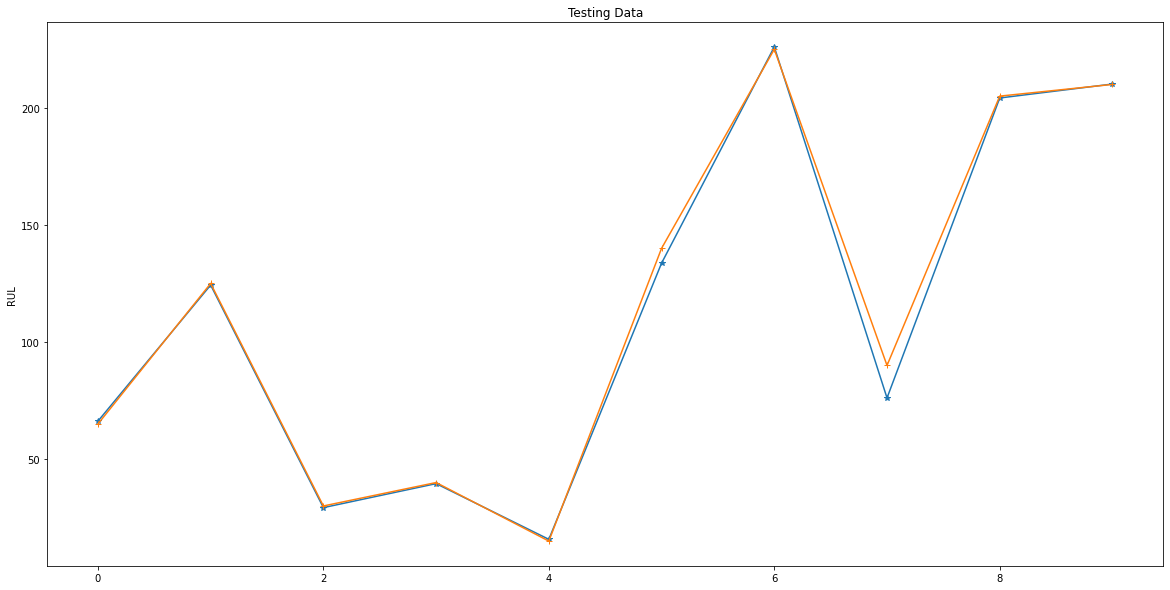

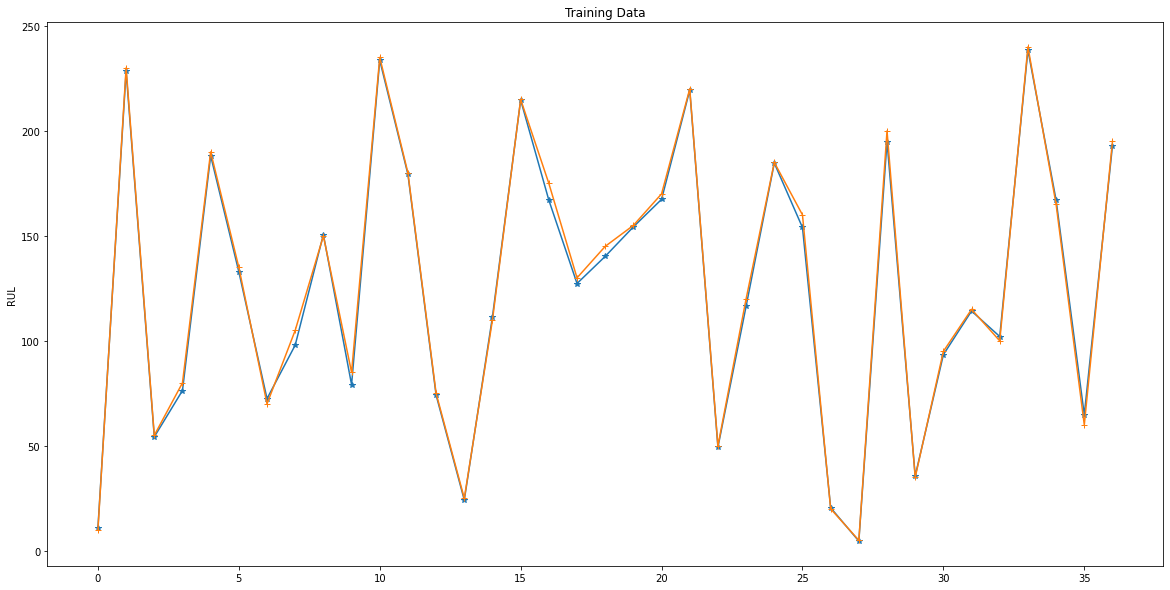

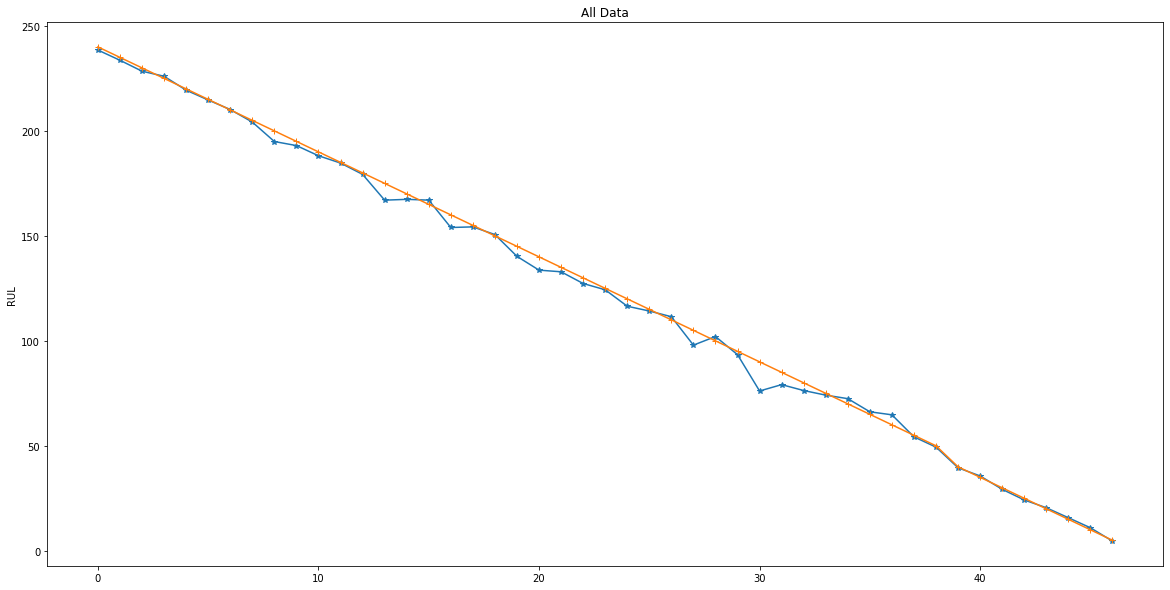

In [ ]:
### validation set
# xgbr.fit(X_train2, y_train2)
pred  = xgbr.predict(X_cv1)
print ("cross validation  :" , mean_squared_error(pred, y_cv1))

plt.figure(figsize = (20, 10))
plt.title("Testing Data")
plt.ylabel("RUL")
plt.plot(pred*denorm, marker = "*", )
plt.plot(y_cv1*denorm, marker = "+")

### train set
# xgbr.fit(X_train2, y_train2)
pred1  = xgbr.predict(X_train1)
print ("train set  :", mean_squared_error(pred1, y_train1))

plt.figure(figsize = (20, 10))
plt.title("Training Data")
plt.ylabel("RUL")
plt.plot(pred1*denorm, marker = "*", )
plt.plot(y_train1*denorm, marker = "+")


### whole data
#xgbr.fit(X, y[0])

pred_fulldata  = xgbr.predict(X1)
#print ("train set  :", mean_squared_error(pred_fulldata, y[0]))
print ("train set  :", mean_squared_error(pred_fulldata, y1[0]))

plt.figure(figsize = (20, 10))
plt.title("All Data")
plt.ylabel("RUL")
plt.plot(pred_fulldata*denorm, marker = "*", )
#plt.plot(y[0], marker = "+")
plt.plot(y1[0]*denorm, marker = "+")

Testing on unit 2

cross validation  : 2.0359702929769895e-05
train set  : 9.72121417246661e-06
train set  : 1.1984722418701348e-05


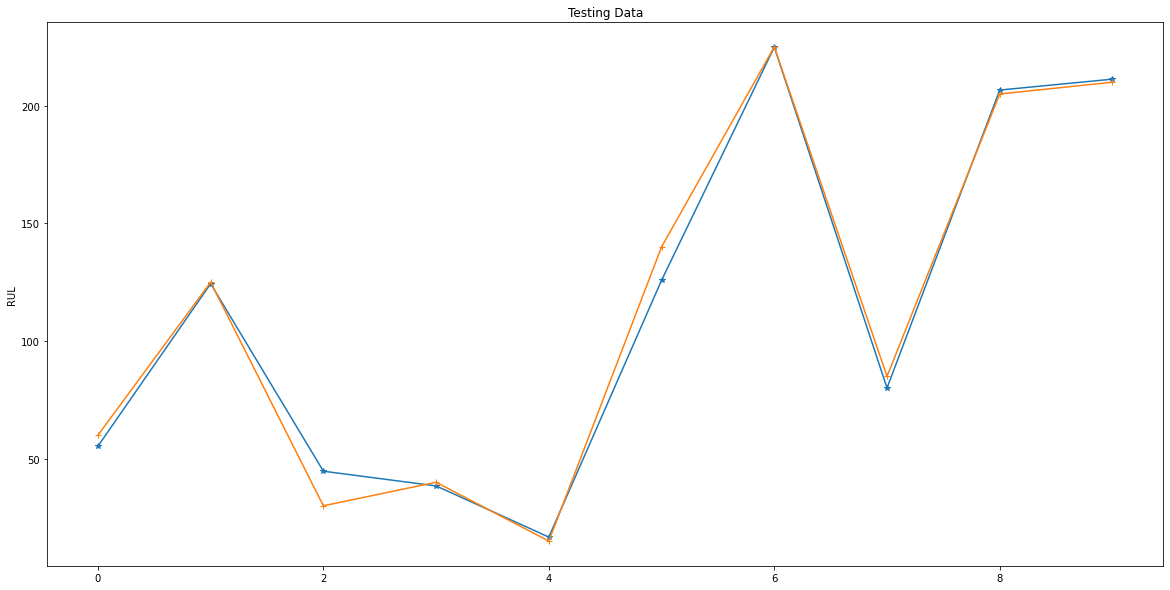

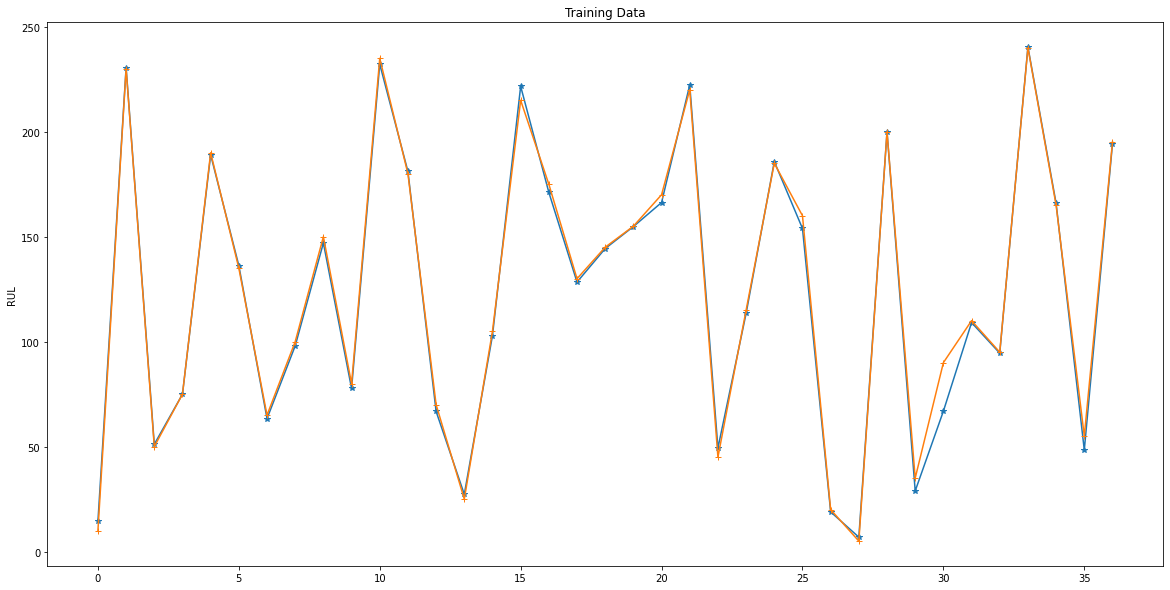

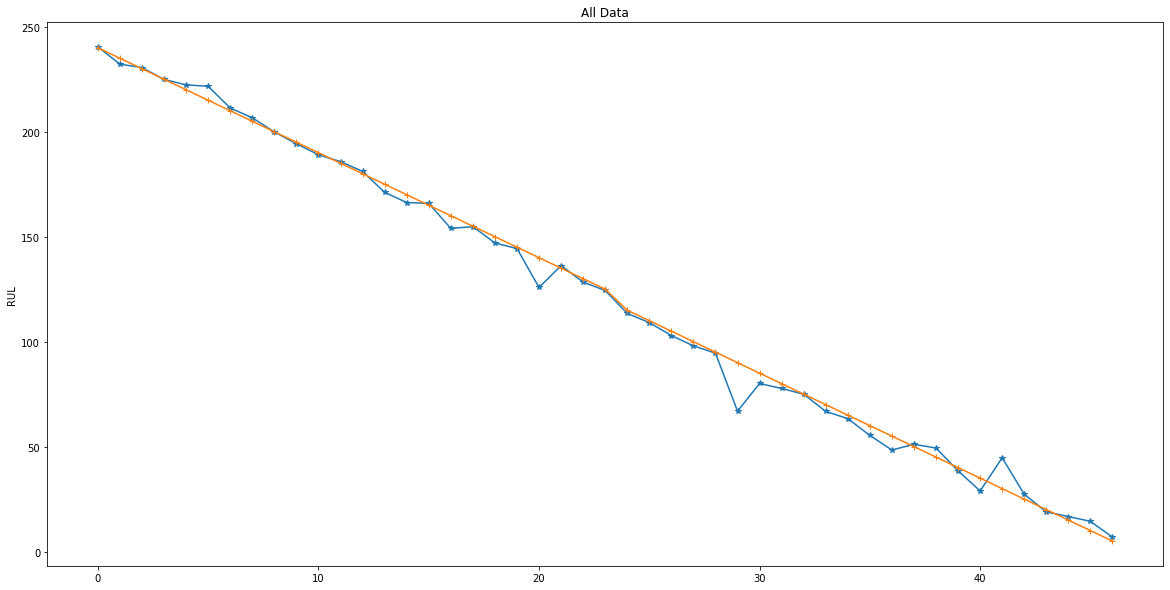

In [ ]:
### validation set
# xgbr.fit(X_train2, y_train2)
pred  = xgbr.predict(X_cv2)
print ("cross validation  :" , mean_squared_error(pred, y_cv2))

plt.figure(figsize = (20, 10))
plt.title("Testing Data")
plt.ylabel("RUL")
plt.plot(pred*denorm, marker = "*", )
plt.plot(y_cv2*denorm, marker = "+")

### train set
# xgbr.fit(X_train2, y_train2)
pred1  = xgbr.predict(X_train2)
print ("train set  :", mean_squared_error(pred1, y_train2))

plt.figure(figsize = (20, 10))
plt.title("Training Data")
plt.ylabel("RUL")
plt.plot(pred1*denorm, marker = "*", )
plt.plot(y_train2*denorm, marker = "+")


### whole data
#xgbr.fit(X, y[0])

pred_fulldata  = xgbr.predict(X2)
#print ("train set  :", mean_squared_error(pred_fulldata, y[0]))
print ("train set  :", mean_squared_error(pred_fulldata, y2[0]))

plt.figure(figsize = (20, 10))
plt.title("All Data")
plt.ylabel("RUL")
plt.plot(pred_fulldata*denorm, marker = "*", )
#plt.plot(y[0], marker = "+")
plt.plot(y2[0]*denorm, marker = "+")

Testing on unit 3

cross validation  : 1.891366249955434e-06
train set  : 3.174409964688107e-06
train set  : 2.8969951074486104e-06


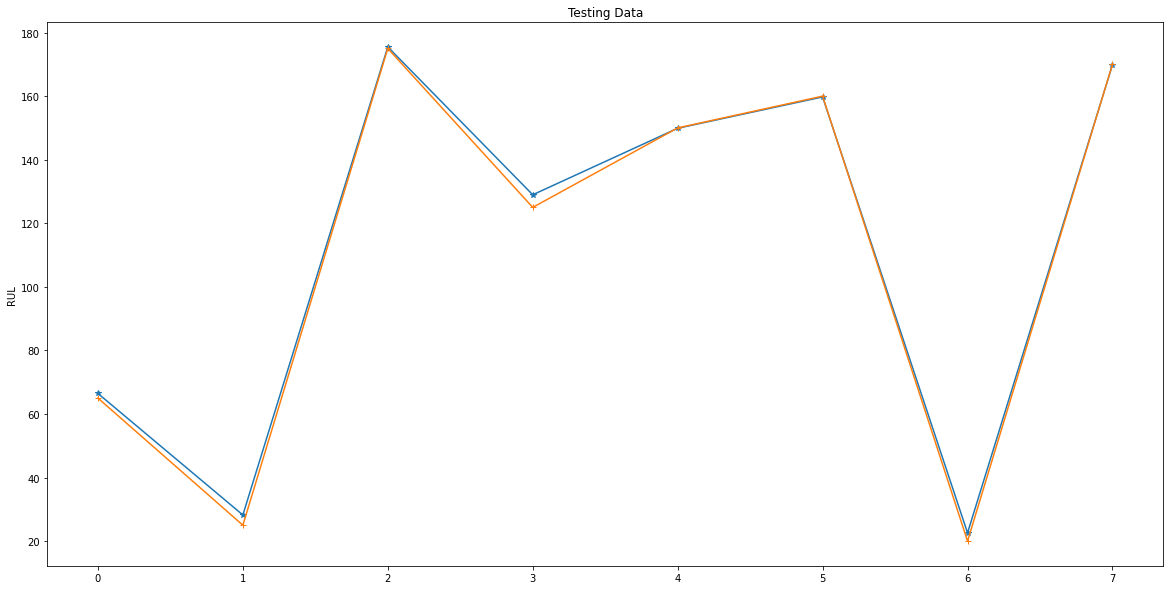

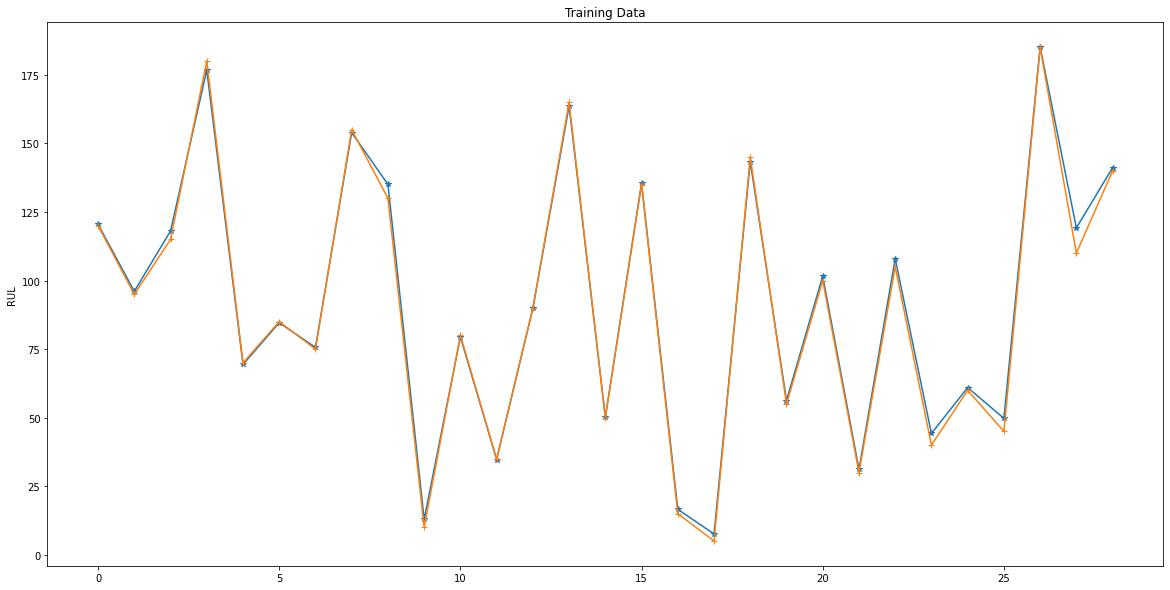

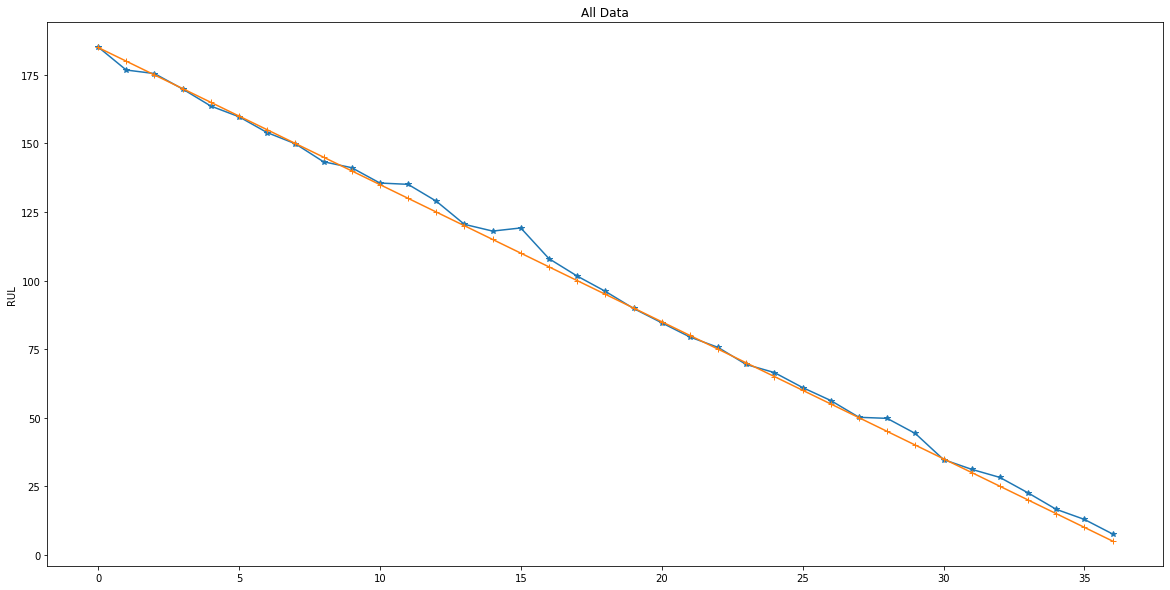

In [ ]:
### validation set
# xgbr.fit(X_train2, y_train2)
pred  = xgbr.predict(X_cv3)
print ("cross validation  :" , mean_squared_error(pred, y_cv3))

plt.figure(figsize = (20, 10))
plt.title("Testing Data")
plt.ylabel("RUL")
plt.plot(pred*denorm, marker = "*", )
plt.plot(y_cv3*denorm, marker = "+")

### train set
# xgbr.fit(X_train2, y_train2)
pred1  = xgbr.predict(X_train3)
print ("train set  :", mean_squared_error(pred1, y_train3))

plt.figure(figsize = (20, 10))
plt.title("Training Data")
plt.ylabel("RUL")
plt.plot(pred1*denorm, marker = "*", )
plt.plot(y_train3*denorm, marker = "+")


### whole data
#xgbr.fit(X, y[0])

pred_fulldata  = xgbr.predict(X3)
#print ("train set  :", mean_squared_error(pred_fulldata, y[0]))
print ("train set  :", mean_squared_error(pred_fulldata, y3[0]))

plt.figure(figsize = (20, 10))
plt.title("All Data")
plt.ylabel("RUL")
plt.plot(pred_fulldata*denorm, marker = "*", )
plt.plot(y3[0]*denorm, marker = "+")

In [ ]:
train1_agg.head()

,spindle_load,x,y,current_mean,current_std,current_max,current_skew,vibration_1_thres100_mean,vibration_1_thres100_std,vibration_1_thres100_max,vibration_1_thres100_skew,vibration_2_thres100_mean,vibration_2_thres100_std,vibration_2_thres100_max,vibration_2_thres100_skew,vibration_1_thres100_rms,vibration_1_thres100_kurt,vibration_1_thres100_cest_fct,vibration_2_thres100_rms,vibration_2_thres100_kurt,vibration_2_thres100_cest_fct,RUL,Cycle,UnitNumber
0,0.914081,-356.155884,44.528058,-11.144181,15.047187,16.499980,-0.667825,0.032376,0.001531,0.037220,0.943986,-0.013055,0.003116,-0.004245,0.369418,0.032412,0.879174,1.148343,0.013422,-0.047324,-0.316309,240,1,1
1,13.331341,-737.676705,115.590290,-0.318225,3.310288,4.773624,0.000877,0.033744,0.001075,0.035050,-0.790154,-0.009465,0.001129,-0.007995,-0.846165,0.033761,-0.611434,1.038168,0.009532,0.139301,-0.838746,235,2,1
2,13.701669,-737.856319,105.071377,-0.330913,3.247888,4.648541,-0.001015,0.030841,0.000615,0.031982,0.430435,-0.012528,0.000621,-0.011608,-0.738537,0.030847,-0.985877,1.036816,0.012544,0.125829,-0.925403,230,3,1
3,13.355145,-736.889246,114.687300,-0.322211,3.132506,4.413352,-0.001984,0.028955,0.000676,0.030533,0.715187,-0.013793,0.000482,-0.013162,-0.328034,0.028963,-0.668608,1.054205,0.013801,-0.900349,-0.953728,225,4,1
4,13.851032,-757.617073,119.884201,-0.317865,3.238111,4.595174,0.002794,0.030467,0.000436,0.031239,-0.064887,-0.012187,0.000754,-0.010854,0.667846,0.030470,-0.921646,1.025257,0.012210,-1.137726,-0.888960,220,5,1


# Testing XGBoost model on challenge data

Testing on challenge 1 data

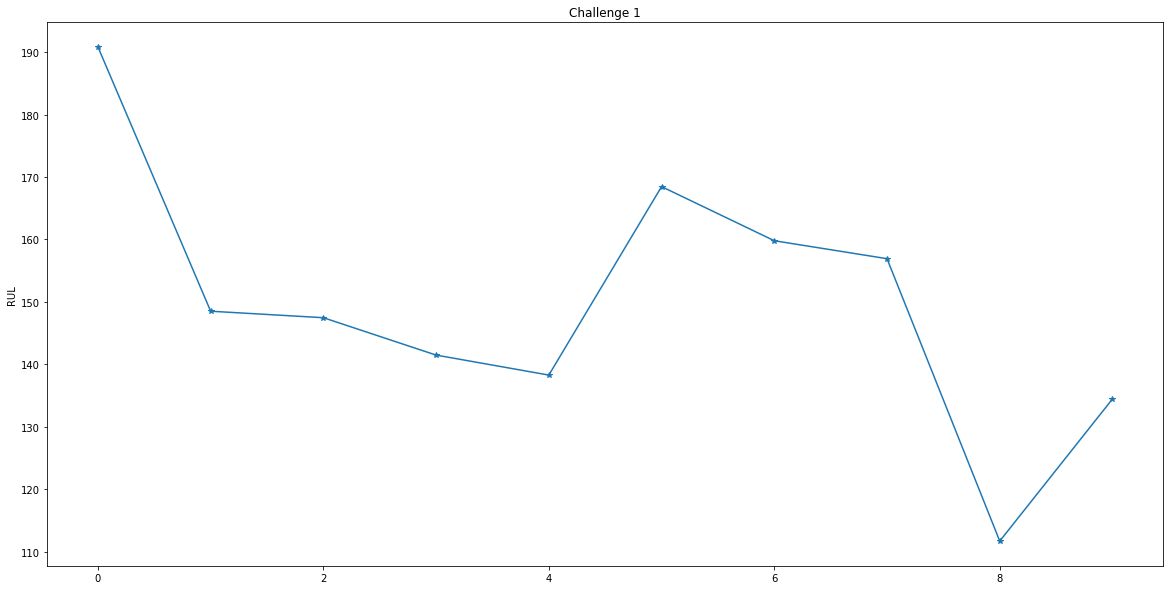

In [ ]:
X2 = test1_agg.drop(["RUL"], axis = 1)

pred_fulldata  = xgbr.predict(X2)

ticks = [x for x in range(len(pred_fulldata))]

plt.figure(figsize = (20, 10))
plt.title("Challenge 1")
plt.ylabel("RUL")
plt.plot(ticks, pred_fulldata*denorm, marker = "*", )

Testing on challenge 2 data

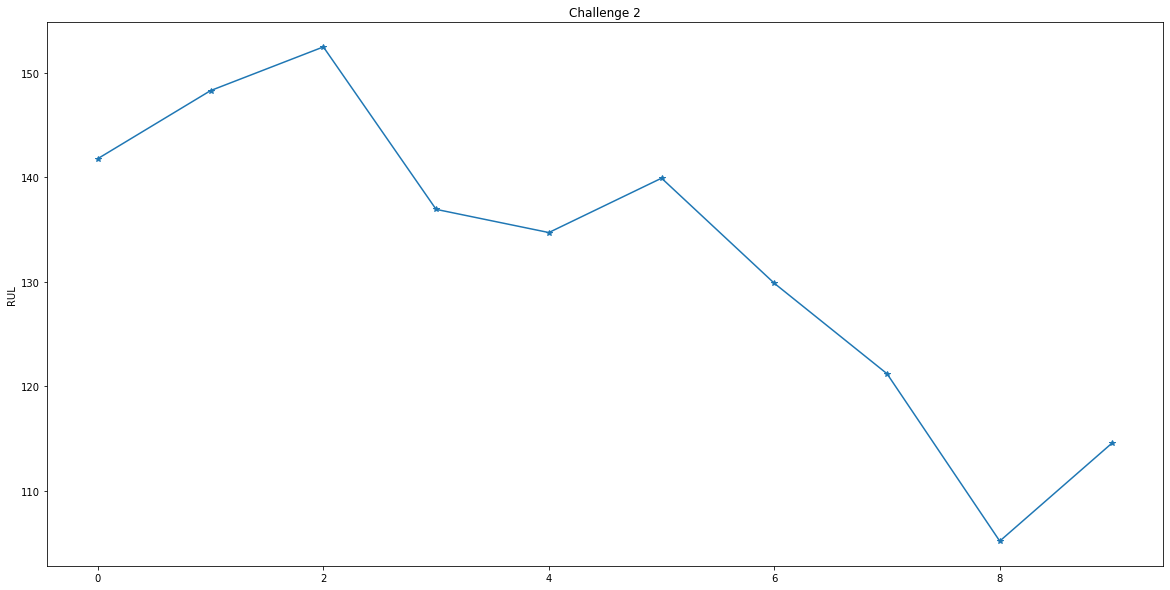

In [ ]:
X2 = test2_agg.drop(["RUL"], axis = 1)

pred_fulldata  = xgbr.predict(X2)

ticks = [x for x in range(len(pred_fulldata))]

plt.figure(figsize = (20, 10))
plt.title("Challenge 2")
plt.ylabel("RUL")
plt.plot(ticks, pred_fulldata*denorm, marker = "*", )

Testing on challenge 3 data

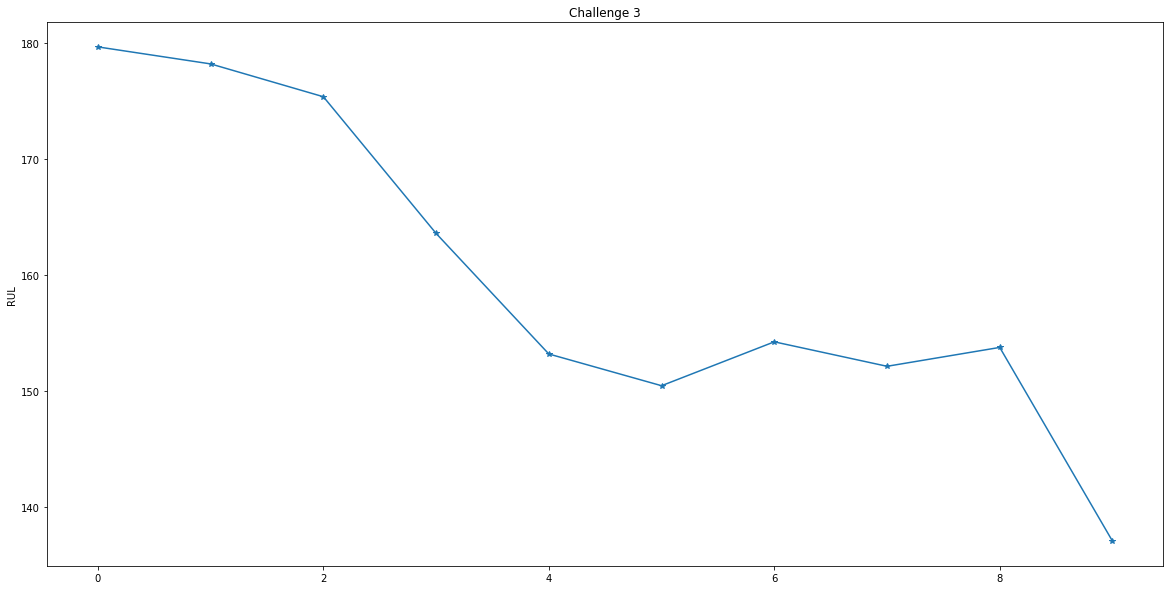

In [ ]:
X2 = test3_agg.drop(["RUL"], axis = 1)

pred_fulldata  = xgbr.predict(X2)

ticks = [x for x in range(len(pred_fulldata))]

plt.figure(figsize = (20, 10))
plt.title("Challenge 3")
plt.ylabel("RUL")
plt.plot(ticks, pred_fulldata*denorm, marker = "*", )

Testing on challenge 4 data

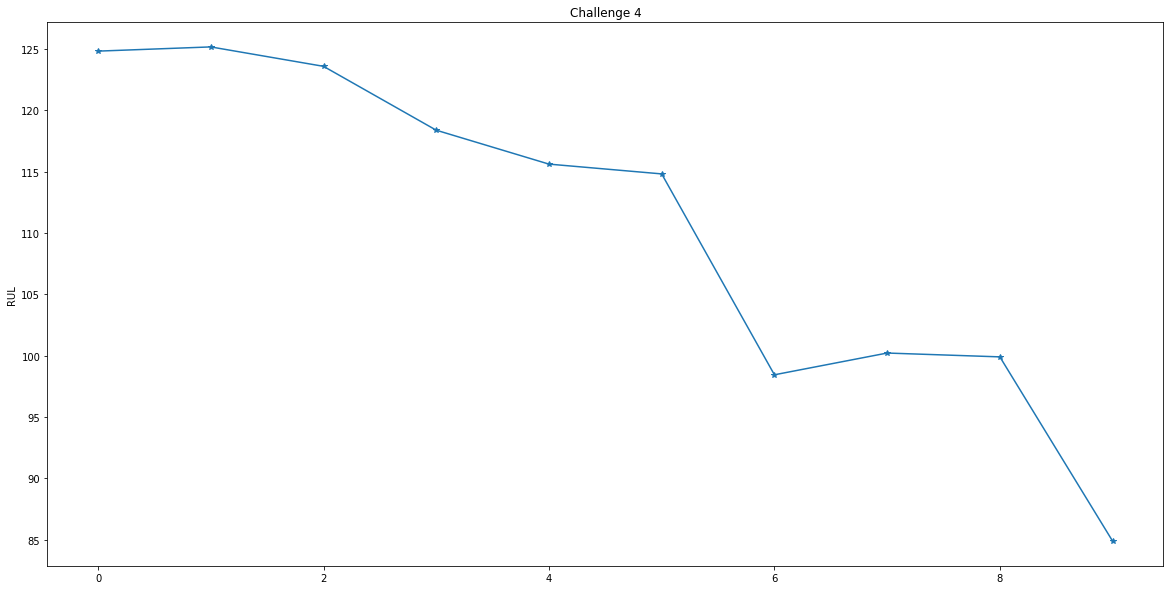

In [ ]:
X2 = test4_agg.drop(["RUL"], axis = 1)

pred_fulldata  = xgbr.predict(X2)

ticks = [x for x in range(len(pred_fulldata))]

plt.figure(figsize = (20, 10))
plt.title("Challenge 4")
plt.ylabel("RUL")
plt.plot(ticks, pred_fulldata*denorm, marker = "*", )

Testing on challenge 5 data

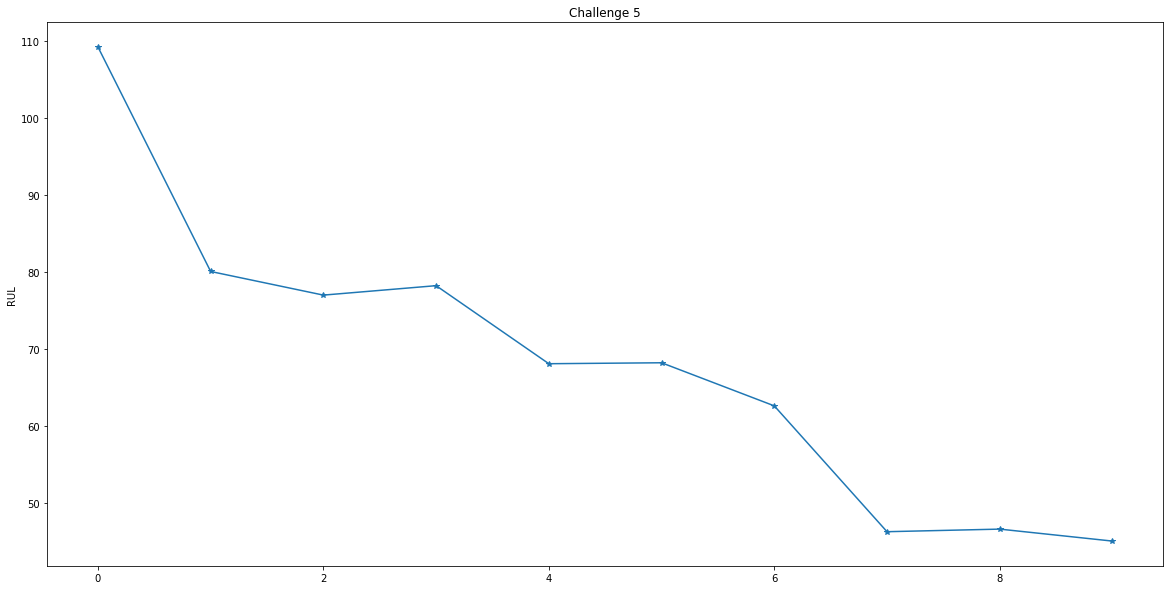

In [ ]:
X2 = test5_agg.drop(["RUL"], axis = 1)

pred_fulldata  = xgbr.predict(X2)

ticks = [x for x in range(len(pred_fulldata))]

plt.figure(figsize = (20, 10))
plt.title("Challenge 5")
plt.ylabel("RUL")
plt.plot(ticks, pred_fulldata*denorm, marker = "*", )

Predicting Remaining Useful Life with linear regression methods

In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor

In [ ]:
def min_max_rul_est(df):
    X = df.drop(["RUL"], axis = 1)
    pred_fulldata  = xgbr.predict(X)

    y = np.array(pred_fulldata*denorm)
    y = np.reshape(np.array(y), (len(y), 1))

    return interp(list(y))

In [ ]:
def interp(lis):
    ticks = [x for x in range(len(lis))]
    mx=max(lis)
    mn=min(lis)
    t0=lis.index(mx)
    t1=lis.index(mn)
    slope=(mn-mx)/(t1-t0)
    intercept=mx-slope*t0
    rul=slope*9+intercept
    return rul

In [ ]:
def huber_rul_est(df):
    ticks = [x for x in range(len(df))]
    X = df.drop(["RUL"], axis = 1)
    pred_fulldata  = xgbr.predict(X)

    y = np.array(pred_fulldata*denorm)
    y = np.reshape(np.array(y), (len(y), 1))
    x = np.array(ticks).T
    x = x[:, np.newaxis]

    huber = HuberRegressor()
    model = huber.fit(x,np.array(y).reshape(-1,1))
    return model.predict(np.array(9).reshape(-1,1))

In [ ]:
def predict_rul(model, val):
    return model.coef_[0] * val + model.intercept_[0]

In [ ]:
def linear_rul_est(df):
    X = df.drop(["RUL"], axis = 1)

    pred_fulldata  = xgbr.predict(X)

    ticks = [x for x in range(len(pred_fulldata))]

    y = np.array(pred_fulldata*denorm)
    y = np.reshape(np.array(y), (len(y), 1))
    x = np.array(ticks).T
    x = x[:, np.newaxis]

    ols = LinearRegression()
    model = ols.fit(x, y)

    rul = predict_rul(model, 9)
    return rul

Min and Max estimation of RUL

In [ ]:
predictions=[]
predictions.append(min_max_rul_est(test1_agg))
predictions.append(min_max_rul_est(test2_agg))
predictions.append(min_max_rul_est(test3_agg))
predictions.append(min_max_rul_est(test4_agg))
predictions.append(min_max_rul_est(test5_agg))
predictions

[array([101.77201799]),
 array([97.31927101]),
 array([137.05095294]),
 array([84.87531046]),
 array([45.08610135])]

In [ ]:
predictions=[]
predictions.append(huber_rul_est(test1_agg))
predictions.append(huber_rul_est(test2_agg))
predictions.append(huber_rul_est(test3_agg))
predictions.append(huber_rul_est(test4_agg))
predictions.append(huber_rul_est(test5_agg))
predictions

[array([135.08001244]),
 array([114.31723016]),
 array([139.90891795]),
 array([92.45361559]),
 array([42.91114411])]

In [ ]:
predictions=[]
predictions.append(linear_rul_est(test1_agg))
predictions.append(linear_rul_est(test2_agg))
predictions.append(linear_rul_est(test3_agg))
predictions.append(linear_rul_est(test4_agg))
predictions.append(linear_rul_est(test5_agg))
predictions

[array([132.51992809]),
 array([112.89895923]),
 array([140.62601734]),
 array([91.1104868]),
 array([40.56913711])]